# Building and evaluating a discrete-time neural network

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.distributions.dirichlet import Dirichlet
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load the support dataset

In [2]:
def load_support_dataset(random_state=0):

    FILL_VALUES = {
        'alb': 3.5,
        'pafi': 333.3,
        'bili': 1.01,
        'crea': 1.01,
        'bun': 6.51,
        'wblc': 9.,
        'urine': 2502.
    }

    COLUMNS_TO_DROP = [
        'aps', 'sps', 'surv2m', 'surv6m', 'prg2m',
        'prg6m', 'dnr', 'dnrday', 'sfdm2', 'hospdead'
    ]

    df = (
        pd.read_csv('../data/support2.csv')
        .drop(COLUMNS_TO_DROP,axis=1)
        .fillna(value=FILL_VALUES)
        .sample(frac=1, random_state=random_state)
    )

    # one-hot encode categorical variables
    # converts each value of categorical variable to be a separate column with each row value being a True or False
    df = pd.get_dummies(df, dummy_na=True)

    # fill missing values to the median
    df = df.fillna(df.median())

    # standardize numeric columns
    numeric_cols = df.dtypes == 'float64'
    df.loc[:, numeric_cols] = df.loc[:, numeric_cols].transform(
        lambda x: (x - x.mean()) / x.std())
    
    features = (
        df
        .drop(['death', 'd.time'], axis=1)
        .values
        .astype(float)
    )
    
    event_indicator = df['death'].values.astype(float)
    event_time = df['d.time'].values.astype(float)

    return features, event_indicator, event_time

In [29]:
X, s, t = load_support_dataset()

In [4]:
test_idx = len(X) * 4 // 5 ## dividing the data into train and test sets where training on 80% of the data and testing on the rest of the 20%

### defining the train and test set

train_X, train_s, train_t = (arr[:test_idx] for arr in (X, s, t))
test_X, test_s, test_t = (arr[test_idx:] for arr in (X, s, t))

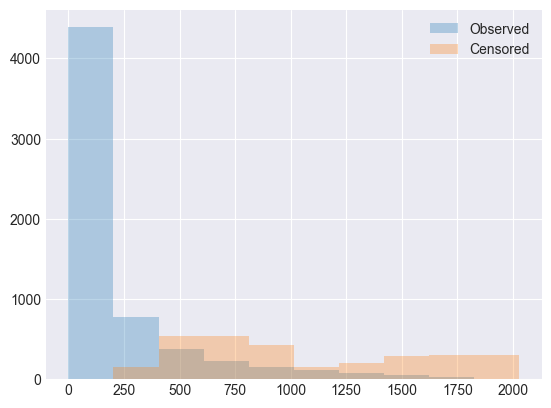

In [5]:
BIN_BOUNDARIES = np.arange(11) * (t.max() / 10)

plt.hist(t[s == 1], alpha=.3, bins=BIN_BOUNDARIES, label='Observed')
plt.hist(t[s == 0], alpha=.3, bins=BIN_BOUNDARIES, label='Censored')
plt.legend()
plt.show()

## Define a Simple NN

In [12]:
class DiscreteTimeNN(torch.nn.Module):

    def __init__(self, hidden_layer_sizes, num_bins):
        super(DiscreteTimeNN, self).__init__()

        self.encoder_layers = [
            torch.nn.LazyLinear(size)
            for size in hidden_layer_sizes
        ]
        
        ### defining the layers in the NN model 
        ## activation layer with ReLU, prediction layer or hidden layers use LazyLinear and output layer uses softmax
        self.activation = torch.nn.ReLU()
        self.prediction_head = torch.nn.LazyLinear(num_bins + 1)
        # self.softmax = torch.nn.Softmax(-1)

    def forward(self, x):
        
        for layer in self.encoder_layers:
            x = layer(x)
            x = self.activation(x)
            
        x = self.prediction_head(x)
        alphas = F.relu(x) + 1

        return alphas

## Define Loss for the Discrete Time to Event model

### NLL Loss

In [ ]:
class EvidentialDiscreteFailureTimeLoss(torch.nn.Module):
    
    def __init__(self, bin_boundaries, tolerance=1e-8, annealing_step=10):
        super(EvidentialDiscreteFailureTimeLoss, self).__init__()
        
        # Discrete time bin boundaries
        self.bin_starts = torch.tensor(bin_boundaries[:-1])
        self.bin_ends = torch.tensor(bin_boundaries[1:])
        self.bin_lengths = self.bin_ends - self.bin_starts
        
        # Tolerance to avoid log(0) issues
        self.tolerance = tolerance
        
        # Annealing coefficient for KL divergence
        self.annealing_step = annealing_step

    def _discretize_times(self, times):
        # Determine which time bins the event times fall into
        return (
            (times[:, None] > self.bin_starts[None, :])
            & (times[:, None] <= self.bin_ends[None, :])
        )

    def _get_proportion_of_bins_completed(self, times):
        # Calculate the proportion of each bin that is completed
        return torch.maximum(
            torch.minimum(
                (times[:, None] - self.bin_starts[None, :]) / self.bin_lengths[None, :],
                torch.tensor(1.0)
            ),
            torch.tensor(0.0)
        )

    def kl_divergence(self, alpha, num_classes, device=None):
        
        if not device:
            device = alpha.device  
        ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
        sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
        
        first_term = (
            torch.lgamma(sum_alpha)
            - torch.lgamma(alpha).sum(dim=1, keepdim=True)
            + torch.lgamma(ones).sum(dim=1, keepdim=True)
            - torch.lgamma(ones.sum(dim=1, keepdim=True))
        )

        second_term = ((alpha - ones)
           .mul(torch.digamma(alpha) 
           - torch.digamma(sum_alpha))
           .sum(dim=1, keepdim=True)
        )
        
        kl = first_term + second_term
        return kl

    
    def forward(self, alphas, event_indicators, event_times, current_epoch):
        """
        alphas: Dirichlet parameters from model (shape: [batch_size, num_bins + 1])
        event_indicators: Binary indicators if the event occurred (1) or was censored (0)
        event_times: Observed time to event or censoring (shape: [batch_size])
        current_epoch: Current epoch number for annealing the KL term
        """
        
        # Dirichlet distribution based on alpha parameters
        dirichlet_dist = Dirichlet(alphas)
        predictions = dirichlet_dist.mean  # Expected probabilities for each bin
        
        # Calculate event and nonevent likelihoods
        event_likelihood = torch.sum(
            self._discretize_times(event_times) * predictions[:, :-1],
            -1
        ) + self.tolerance

        nonevent_likelihood = 1 - torch.sum(
            self._get_proportion_of_bins_completed(event_times) * predictions[:, :-1],
            -1
        ) + self.tolerance

        # Compute negative log-likelihood loss
        log_likelihood = event_indicators * torch.log(event_likelihood) + (1 - event_indicators) * torch.log(nonevent_likelihood)
        nll_loss = -torch.mean(log_likelihood)
        
        # KL divergence regularization term
        # kl_divergence = torch.distributions.kl.kl_divergence(
        #     dirichlet_dist, Dirichlet(torch.ones_like(alphas))
        # )
        # kl_loss = torch.mean(kl_divergence)
        

        # Calculate KL Divergence term 
        kl_loss = torch.mean(self.kl_divergence(alphas, alphas.size(1), alphas.device))
        
        # Annealing coefficient to gradually introduce KL term
    
        annealing_coefficient = min(1.0, current_epoch / self.annealing_step)
        
        # Total evidential loss
    
        evidential_loss = nll_loss + annealing_coefficient * kl_loss
        
        return evidential_loss 


### MSE Loss without censoring

In [ ]:
class EvidentialDiscreteFailureTimeMSELoss(torch.nn.Module):
    
    def __init__(self, bin_boundaries, tolerance=1e-8, annealing_step=10):
        super(EvidentialDiscreteFailureTimeMSELoss, self).__init__()
        
        # Discrete time bin boundaries
        self.bin_starts = torch.tensor(bin_boundaries[:-1])
        self.bin_ends = torch.tensor(bin_boundaries[1:])
        self.bin_lengths = self.bin_ends - self.bin_starts
        
        # Tolerance to avoid division by zero
        self.tolerance = tolerance
        
        # Annealing coefficient for KL divergence
        self.annealing_step = annealing_step

    def _discretize_times(self, times):
        # Determine which time bins the event times fall into
        return (
            (times[:, None] > self.bin_starts[None, :])
            & (times[:, None] <= self.bin_ends[None, :])
        )

    def kl_divergence(self, alpha, num_classes, device=None):
        if not device:
            device = alpha.device  
        ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
        sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
        
        first_term = (
            torch.lgamma(sum_alpha)
            - torch.lgamma(alpha).sum(dim=1, keepdim=True)
            + torch.lgamma(ones).sum(dim=1, keepdim=True)
            - torch.lgamma(ones.sum(dim=1, keepdim=True))
        )

        second_term = ((alpha - ones)
           .mul(torch.digamma(alpha) 
           - torch.digamma(sum_alpha))
           .sum(dim=1, keepdim=True)
        )
        
        kl = first_term + second_term
        return kl

    def forward(self, alphas, event_indicators, event_times, current_epoch):
        
        dirichlet_dist = Dirichlet(alphas)
        predictions = dirichlet_dist.mean  # Expected probabilities for each bin
        variance = dirichlet_dist.variance  # Variance for each bin

        # Discretize times for uncensored samples (one-hot encoding)
        target_bins = self._discretize_times(event_times).float()

        # Error term: (y_ij - p_hat_ij)^2
        error_term = (target_bins - predictions[:, :-1]) ** 2

        # Variance term: p_hat_ij * (1 - p_hat_ij) / (S_i + 1)
        sum_alpha = torch.sum(alphas, dim=1, keepdim=True)
        variance_term = predictions[:, :-1] * (1 - predictions[:, :-1]) / (sum_alpha + 1)

        # Total MSE with censoring adjustment
        mse_loss = torch.mean(error_term + variance_term)

        # KL divergence regularization term
        kl_loss = torch.mean(self.kl_divergence(alphas, alphas.size(1), alphas.device))
        
        # Annealing coefficient to gradually introduce KL term
        annealing_coefficient = min(1.0, current_epoch / self.annealing_step)
        
        # Total evidential loss with MSE, variance regularization, and KL divergence
        evidential_loss = mse_loss + annealing_coefficient * kl_loss
        
        return evidential_loss


### MSE Loss with censoring

In [13]:
class EvidentialDiscreteFailureTimeMSELoss(torch.nn.Module):
    
    def __init__(self, bin_boundaries, tolerance=1e-8, annealing_step=10):
        super(EvidentialDiscreteFailureTimeMSELoss, self).__init__()
        
        # Discrete time bin boundaries
        self.bin_starts = torch.tensor(bin_boundaries[:-1])
        self.bin_ends = torch.tensor(bin_boundaries[1:])
        self.bin_lengths = self.bin_ends - self.bin_starts
        
        # Tolerance to avoid division by zero
        self.tolerance = tolerance
        
        # Annealing coefficient for KL divergence
        self.annealing_step = annealing_step

    def _discretize_times(self, times):
        # Determine which time bins the event times fall into
        return (
            (times[:, None] > self.bin_starts[None, :])
            & (times[:, None] <= self.bin_ends[None, :])
        )

    def kl_divergence(self, alpha, num_classes, device=None):
        if not device:
            device = alpha.device  
        ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
        sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
        
        first_term = (
            torch.lgamma(sum_alpha)
            - torch.lgamma(alpha).sum(dim=1, keepdim=True)
            + torch.lgamma(ones).sum(dim=1, keepdim=True)
            - torch.lgamma(ones.sum(dim=1, keepdim=True))
        )

        second_term = ((alpha - ones)
           .mul(torch.digamma(alpha) 
           - torch.digamma(sum_alpha))
           .sum(dim=1, keepdim=True)
        )
        
        kl = first_term + second_term
        return kl

    def forward(self, alphas, event_indicators, event_times, current_epoch):
        
        dirichlet_dist = Dirichlet(alphas)
        predictions = dirichlet_dist.mean  # Expected probabilities for each bin

        # Total sum of Dirichlet parameters
        sum_alpha = torch.sum(alphas, dim=1, keepdim=True)

        # Discretize times for uncensored samples (one-hot encoding)
        target_bins = self._discretize_times(event_times).float()

        # Error and Variance terms
        error_term = torch.zeros_like(event_indicators, dtype=torch.float32)
        variance_term = torch.zeros_like(event_indicators, dtype=torch.float32)
        
        for i in range(event_indicators.size(0)):
            if event_indicators[i] == 1:  # Uncensored
                error_term[i] = torch.sum((target_bins[i] - predictions[i, :-1]) ** 2)
                variance_term[i] = torch.sum(predictions[i, :-1] * (1 - predictions[i, :-1]) / (sum_alpha[i] + 1))

            else:  # Censored
                # Find the bin containing the censoring time
                censoring_bin = torch.where(self.bin_starts <= event_times[i])[0][-1]
                survival_prob = torch.sum(predictions[i, censoring_bin:])
                error_term[i] = (1 - survival_prob) ** 2
                variance_term[i] = torch.sum(predictions[i, censoring_bin:] * (1 - predictions[i, censoring_bin:]) / (sum_alpha[i] + 1))

        # Total MSE with censoring adjustment
        mse_loss = torch.mean(error_term + variance_term)

        # KL divergence regularization term
        kl_loss = torch.mean(self.kl_divergence(alphas, alphas.size(1), alphas.device))
        
        # Annealing coefficient to gradually introduce KL term
        annealing_coefficient = min(1.0, current_epoch / self.annealing_step)
        
        # Total evidential loss with MSE, variance regularization, and KL divergence
        evidential_loss = mse_loss + annealing_coefficient * kl_loss
        
        return evidential_loss


## Run the model - NLL Loss

In [ ]:
#### model with the NLL loss

model = DiscreteTimeNN((100, ), 10)
loss_fn = EvidentialDiscreteFailureTimeLoss(BIN_BOUNDARIES)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def get_batches(*arrs, batch_size=1):
    l = len(arrs[0])
    for ndx in range(0, l, batch_size):
        yield (torch.tensor(arr[ndx:min(ndx + batch_size, l)], dtype=torch.float) for arr in arrs)

In [ ]:
NUM_EPOCHS = 70

train_loss = []
test_loss = []
train_pred = []

for epoch_idx in range(NUM_EPOCHS):
    
    epoch_train_loss = []
    epoch_test_loss = []

    for batch_X, batch_s, batch_t in get_batches(train_X, train_s, train_t, batch_size=100):

        optimizer.zero_grad()

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        train_pred.append(batch_predictions)
        
        # Compute the loss and its gradients
        loss = loss_fn(batch_predictions, batch_s, batch_t, current_epoch=epoch_idx)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        epoch_train_loss.append(loss.item())

        
    for batch_X, batch_s, batch_t in get_batches(test_X, test_s, test_t, batch_size=100):

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # Compute the loss and its gradients
        loss = loss_fn(batch_predictions, batch_s, batch_t, current_epoch=epoch_idx)
        
        # Gather data and report
        epoch_test_loss.append(loss.item())
        
    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))
            
    print('Completed epoch %i; train loss = %.3f; test loss = %.3f' % (
        epoch_idx, train_loss[-1], test_loss[-1]), end='\r')
          
plt.plot(np.arange(len(train_loss)), train_loss, label='Training Loss')
plt.plot(np.arange(len(test_loss)), test_loss, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (Evidential NLL)')
plt.legend()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Model output (Dirichlet distribution parameters)
test_predictions = (
    model(torch.tensor(test_X, dtype=torch.float))
    .detach()
    .numpy()
)

# Calculate the event probabilities for each bin (mean of Dirichlet distribution)

pred_mean = test_predictions / test_predictions.sum(axis=1, keepdims=True)

# Calculate the 2.5th and 97.5th percentiles 
pred_lower = np.percentile(pred_mean, 2.5, axis=0)
pred_upper = np.percentile(pred_mean, 97.5, axis=0)

# Plot the predicted event probabilities with error bars (95% CI)
plt.bar(
    np.arange(test_predictions.shape[1]),  # Bin positions (e.g., 0 to 10)
    pred_mean.mean(axis=0),                 # Mean predicted probabilities
    yerr=[pred_mean.mean(axis=0) - pred_lower, pred_upper - pred_mean.mean(axis=0)],  # Error bars (95% CI)
    capsize=5
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.title('Predicted Event Probability vs. Number of Bins')
plt.show()


In [ ]:
import sys
sys.path.append('/Volumes/Workbench/Academia/Rotations/EngelhardLab/utils')
from tte_measures import kaplan_meier, xCI, xAUCt, xROCt, xAPt, xPRt

In [ ]:
times = BIN_BOUNDARIES[1:]

cumulative_predicted_risk = np.cumsum(pred_mean, axis=1)[:, :-1]

cp_mean = [0] + list(cumulative_predicted_risk.mean(axis=0))
cp_std = [0] + list(cumulative_predicted_risk.std(axis=0))

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

km_times, km_mean, km_var = kaplan_meier(test_s, test_t)

ax[0].plot(km_times, 1 - km_mean)
ax[0].fill_between(km_times, 1 - km_mean - np.sqrt(km_var), 1 - km_mean + np.sqrt(km_var), alpha=.3)

ax[1].plot([0] + list(times), cp_mean)
ax[1].fill_between(
    [0] + list(times),
    np.array(cp_mean) - np.array(cp_std),
    np.array(cp_mean) + np.array(cp_std),
    alpha=.3
)

plt.show()

In [ ]:
n_bootstrap_samples = 50

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

times = BIN_BOUNDARIES[1:]
time_idx = 6
time = times[time_idx]

cumulative_predicted_risk = np.cumsum(pred_mean, axis=1)[:, :-1]

auct, ci_low, ci_high = xAUCt(
    test_s == 1, test_t, cumulative_predicted_risk, times,
    n_bootstrap_samples=n_bootstrap_samples
)

ax[0].plot(times, auct, 'k-', label='All-All')
ax[0].fill_between(times, ci_low, ci_high, color='k', alpha=.1)

tprt, fprt, _ = xROCt(
    test_s == 1, test_t, cumulative_predicted_risk[:, time_idx], time
)

ax[1].plot(
    fprt, tprt, 'k-',
    label='AUC$_t$ = %.2f (%.2f-%.2f)' % (
        auct[time_idx], ci_low[time_idx], ci_high[time_idx]
    )
)

(apt, prevt), (apt_low, prev_low), (apt_high, prev_high) = xAPt(
    test_s == 1, test_t, cumulative_predicted_risk, times,
    return_prevalence=True,
    n_bootstrap_samples=n_bootstrap_samples
)

ax[2].plot(times, apt, 'k-', label='All')
ax[2].fill_between(times, apt_low, apt_high, color='k', alpha=.1)
ax[2].plot(times, prevt, 'k--')#, label='Prevalence at t')

recallt, precisiont, _, prevt = xPRt(
    test_s == 1, test_t, cumulative_predicted_risk[:, time_idx], time
)

ax[3].plot(
    recallt, precisiont, 'k-',
    label='AP$_t$ = %.2f (%.2f-%.2f)' % (
        apt[time_idx], apt_low[time_idx], apt_high[time_idx]
    )
)

ax[3].plot([0, 1], [prevt, prevt], 'k--')#, label='Prevalence at t')

ax[0].plot(times, times * 0 + .5, 'k--')
ax[0].set_ylim([0.45, 1.])
ax[0].set_ylabel('AUC$_t$')
ax[0].set_xlabel('Time (t)')
ax[0].legend()

ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].set_ylabel('True Positive Rate (t=%i)' % time)
ax[1].set_xlabel('False Positive Rate (t=%i)' % time)
ax[1].legend()

ax[2].set_ylabel('AP$_t$')
ax[2].set_xlabel('Time (t)')
ax[2].legend()

ax[3].set_ylabel('Precision (t=%i)' % time)
ax[3].set_xlabel('Recall (t=%i)' % time)
ax[3].legend()

plt.tight_layout()
plt.show()

## Run the model - MSE loss

In [14]:
model = DiscreteTimeNN((100, ), 10)  # Ensure this model outputs Dirichlet parameters, not probabilities
loss_fn = EvidentialDiscreteFailureTimeMSELoss(BIN_BOUNDARIES)
optimizer = torch.optim.Adam(model.parameters())


/Volumes/Workbench/Academia/Software/Miniconda/envs/dev/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [15]:
def get_batches(*arrs, batch_size=1):
    l = len(arrs[0])
    for ndx in range(0, l, batch_size):
        yield (torch.tensor(arr[ndx:min(ndx + batch_size, l)], dtype=torch.float) for arr in arrs)

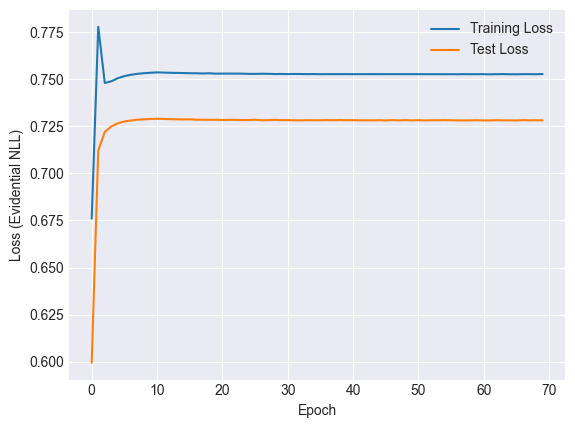

In [16]:
NUM_EPOCHS = 70

train_loss = []
test_loss = []

for epoch_idx in range(NUM_EPOCHS):
    
    epoch_train_loss = []
    epoch_test_loss = []

    for batch_X, batch_s, batch_t in get_batches(train_X, train_s, train_t, batch_size=100):

        optimizer.zero_grad()

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # # Compute the loss and its gradients
        loss = loss_fn(batch_predictions, batch_s, batch_t, current_epoch=epoch_idx)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        epoch_train_loss.append(loss.item())

        
    for batch_X, batch_s, batch_t in get_batches(test_X, test_s, test_t, batch_size=100):

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # Compute the loss and its gradients
        loss = loss_fn(batch_predictions, batch_s, batch_t, current_epoch=epoch_idx)
        
        # Gather data and report
        epoch_test_loss.append(loss.item())
        
    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))
            
    print('Completed epoch %i; train loss = %.3f; test loss = %.3f' % (
        epoch_idx, train_loss[-1], test_loss[-1]), end='\r')
    # print('Completed epoch %i'%(epoch_idx), end='\r')
          
plt.plot(np.arange(len(train_loss)), train_loss, label='Training Loss')
plt.plot(np.arange(len(test_loss)), test_loss, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (Evidential NLL)')
plt.legend()
plt.show()



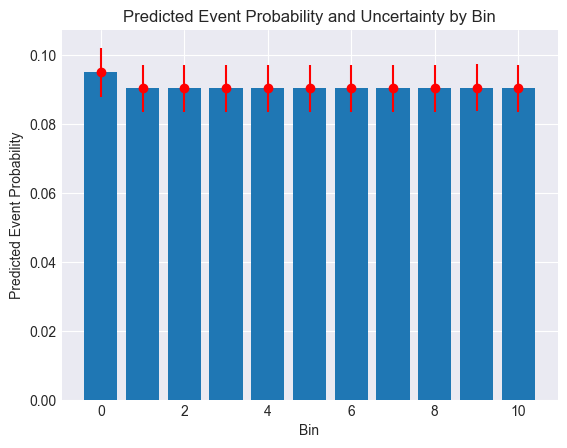

In [17]:
# Model output (Dirichlet distribution parameters)
test_predictions = (model(torch.tensor(test_X, dtype=torch.float)).detach().numpy())

# Calculate the event probabilities for each bin (mean of Dirichlet distribution)

pred_mean = test_predictions / test_predictions.sum(axis=1, keepdims=True)

# Calculate the variance of the Dirichlet distribution for each bin
pred_var = (pred_mean * (1 - pred_mean)) / (test_predictions.sum(axis=1, keepdims=True) + 1)

# Plot the predicted event probabilities with error bars (95% CI) and overlay variance as error bars
plt.bar(
    np.arange(test_predictions.shape[1]),  # Bin positions (e.g., 0 to number of bins)
    pred_mean.mean(axis=0),                 # Mean predicted probabilities
    capsize=5,
    label="Predicted Event Probability"
)

# Overlay variance as an additional measure of uncertainty
plt.errorbar(
    np.arange(test_predictions.shape[1]),
    pred_mean.mean(axis=0),
    yerr=pred_var.mean(axis=0),
    fmt='o',
    color='red',
    label="Uncertainty (Variance)"
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.title('Predicted Event Probability and Uncertainty by Bin')
# plt.legend()
plt.show()


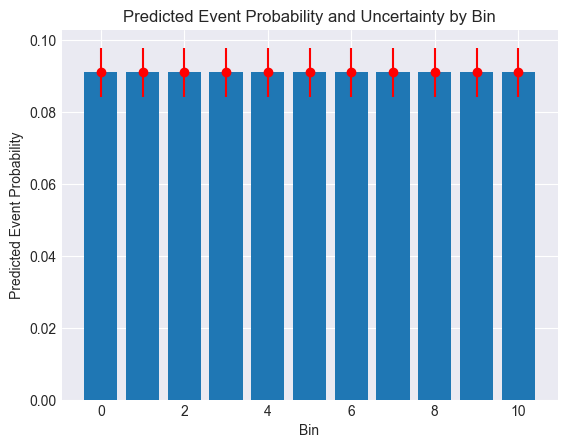

In [18]:
# Model output (Dirichlet distribution parameters)
test_predictions = (model(torch.tensor(test_X[0], dtype=torch.float)).detach().numpy())

# Calculate the event probabilities for each bin (mean of Dirichlet distribution)
pred_mean = test_predictions / test_predictions.sum()

# Calculate the variance of the Dirichlet distribution for each bin
pred_var = (pred_mean * (1 - pred_mean)) / (test_predictions.sum() + 1)

# Plot the predicted event probabilities with error bars (95% CI) and overlay variance as error bars
plt.bar(
    np.arange(test_predictions.shape[0]),  # Bin positions (e.g., 0 to number of bins)
    pred_mean,                 # Mean predicted probabilities
    # yerr=[pred_mean - pred_lower, pred_upper - pred_mean],  # Error bars (95% CI)
    capsize=5,
    label="Predicted Event Probability (95% CI)"
)

# Overlay variance as an additional measure of uncertainty
plt.errorbar(
    np.arange(test_predictions.shape[0]),
    pred_mean,
    yerr=pred_var,
    fmt='o',
    color='red',
    label="Uncertainty (Variance)"
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.title('Predicted Event Probability and Uncertainty by Bin')
# plt.legend()
plt.show()


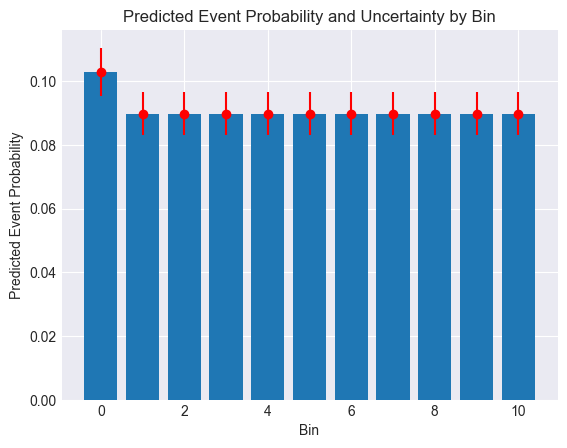

In [19]:
# Model output (Dirichlet distribution parameters)
test_predictions = (model(torch.tensor(test_X[2], dtype=torch.float)).detach().numpy())

# Calculate the event probabilities for each bin (mean of Dirichlet distribution)
pred_mean = test_predictions / test_predictions.sum()

# Calculate the variance of the Dirichlet distribution for each bin
pred_var = (pred_mean * (1 - pred_mean)) / (test_predictions.sum() + 1)

# Plot the predicted event probabilities with error bars (95% CI) and overlay variance as error bars
plt.bar(
    np.arange(test_predictions.shape[0]),  # Bin positions (e.g., 0 to number of bins)
    pred_mean,                 # Mean predicted probabilities
    # yerr=[pred_mean - pred_lower, pred_upper - pred_mean],  # Error bars (95% CI)
    capsize=5,
    label="Predicted Event Probability (95% CI)"
)

# Overlay variance as an additional measure of uncertainty
plt.errorbar(
    np.arange(test_predictions.shape[0]),
    pred_mean,
    yerr=pred_var,
    fmt='o',
    color='red',
    label="Uncertainty (Variance)"
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.title('Predicted Event Probability and Uncertainty by Bin')
# plt.legend()
plt.show()


In [20]:
test_predictions

array([1.1474264, 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       ],
      dtype=float32)

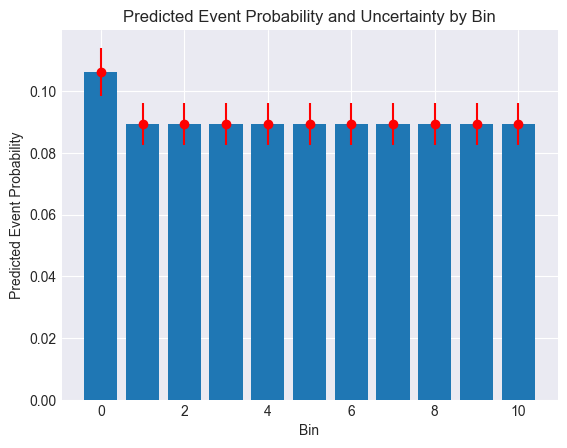

In [21]:
# Model output (Dirichlet distribution parameters)
test_predictions = (model(torch.tensor(test_X[18], dtype=torch.float)).detach().numpy())

# Calculate the event probabilities for each bin (mean of Dirichlet distribution)
pred_mean = test_predictions / test_predictions.sum()

# Calculate the variance of the Dirichlet distribution for each bin
pred_var = (pred_mean * (1 - pred_mean)) / (test_predictions.sum() + 1)

# Plot the predicted event probabilities with error bars (95% CI) and overlay variance as error bars
plt.bar(
    np.arange(test_predictions.shape[0]),  # Bin positions (e.g., 0 to number of bins)
    pred_mean,                 # Mean predicted probabilities
    # yerr=[pred_mean - pred_lower, pred_upper - pred_mean],  # Error bars (95% CI)
    capsize=5,
    label="Predicted Event Probability (95% CI)"
)

# Overlay variance as an additional measure of uncertainty
plt.errorbar(
    np.arange(test_predictions.shape[0]),
    pred_mean,
    yerr=pred_var,
    fmt='o',
    color='red',
    label="Uncertainty (Variance)"
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.title('Predicted Event Probability and Uncertainty by Bin')
# plt.legend()
plt.show()


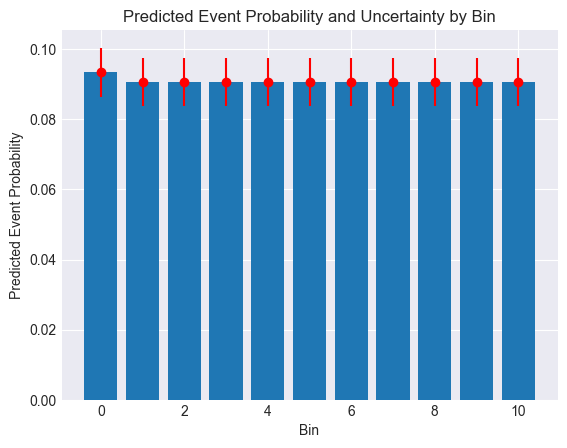

In [28]:
# Model output (Dirichlet distribution parameters)
test_predictions = (model(torch.tensor(test_X[100], dtype=torch.float)).detach().numpy())

# Calculate the event probabilities for each bin (mean of Dirichlet distribution)
pred_mean = test_predictions / test_predictions.sum()

# Calculate the variance of the Dirichlet distribution for each bin
pred_var = (pred_mean * (1 - pred_mean)) / (test_predictions.sum() + 1)

# Calculate the 2.5th and 97.5th percentiles for the confidence interval (95% CI)
pred_lower = np.percentile(pred_mean, 2.5, axis=0)
pred_upper = np.percentile(pred_mean, 97.5, axis=0)

# Plot the predicted event probabilities with error bars (95% CI) and overlay variance as error bars
plt.bar(
    np.arange(test_predictions.shape[0]),  # Bin positions (e.g., 0 to number of bins)
    pred_mean,                 # Mean predicted probabilities
    # yerr=[pred_mean - pred_lower, pred_upper - pred_mean],  # Error bars (95% CI)
    capsize=5,
    label="Predicted Event Probability (95% CI)"
)

# Overlay variance as an additional measure of uncertainty
plt.errorbar(
    np.arange(test_predictions.shape[0]),
    pred_mean,
    yerr=pred_var,
    fmt='o',
    color='red',
    label="Uncertainty (Variance)"
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.title('Predicted Event Probability and Uncertainty by Bin')
# plt.legend()
plt.show()


In [26]:
test_X.shape

(1821, 61)

# Plot the error and variance contributions 

Modify the loss function accordingly

### MSE loss without censoring

In [ ]:
class EvidentialDiscreteFailureTimeMSELoss(torch.nn.Module):
    
    def __init__(self, bin_boundaries, tolerance=1e-8, annealing_step=10):
        super(EvidentialDiscreteFailureTimeMSELoss, self).__init__()
        
        # Discrete time bin boundaries
        self.bin_starts = torch.tensor(bin_boundaries[:-1])
        self.bin_ends = torch.tensor(bin_boundaries[1:])
        self.bin_lengths = self.bin_ends - self.bin_starts
        
        # Tolerance to avoid division by zero
        self.tolerance = tolerance
        
        # Annealing coefficient for KL divergence
        self.annealing_step = annealing_step

    def _discretize_times(self, times):
        # Determine which time bins the event times fall into
        return (
            (times[:, None] > self.bin_starts[None, :])
            & (times[:, None] <= self.bin_ends[None, :])
        )

    def kl_divergence(self, alpha, num_classes, device=None):
        if not device:
            device = alpha.device  
        ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
        sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
        
        first_term = (
            torch.lgamma(sum_alpha)
            - torch.lgamma(alpha).sum(dim=1, keepdim=True)
            + torch.lgamma(ones).sum(dim=1, keepdim=True)
            - torch.lgamma(ones.sum(dim=1, keepdim=True))
        )

        second_term = ((alpha - ones)
           .mul(torch.digamma(alpha) 
           - torch.digamma(sum_alpha))
           .sum(dim=1, keepdim=True)
        )
        
        kl = first_term + second_term
        return kl

    def forward(self, alphas, event_indicators, event_times, current_epoch, return_components=False):
        
        dirichlet_dist = Dirichlet(alphas)
        predictions = dirichlet_dist.mean  # Expected probabilities for each bin
        variance = dirichlet_dist.variance  # Variance for each bin

        # Discretize times for uncensored samples (one-hot encoding)
        target_bins = self._discretize_times(event_times).float()

        # Error term: (y_ij - p_hat_ij)^2
        error_term = (target_bins - predictions[:, :-1]) ** 2

        # Variance term: p_hat_ij * (1 - p_hat_ij) / (S_i + 1)
        sum_alpha = torch.sum(alphas, dim=1, keepdim=True)
        variance_term = predictions[:, :-1] * (1 - predictions[:, :-1]) / (sum_alpha + 1)

        # Total MSE with censoring adjustment
        mse_loss = torch.mean(error_term + variance_term)

        # KL divergence regularization term
        kl_loss = torch.mean(self.kl_divergence(alphas, alphas.size(1), alphas.device))
        
        # Annealing coefficient to gradually introduce KL term
        annealing_coefficient = min(1.0, current_epoch / self.annealing_step)
        
        # Total evidential loss with MSE, variance regularization, and KL divergence
        evidential_loss = mse_loss + annealing_coefficient * kl_loss
        
        if return_components:
            # Return individual components for analysis
            return evidential_loss, mse_loss, annealing_coefficient, kl_loss, torch.mean(error_term), torch.mean(variance_term) 
        else:
            # Return the total loss only
            return evidential_loss


In [ ]:
model = DiscreteTimeNN((100, ), 10)  # Ensure this model outputs Dirichlet parameters, not probabilities
loss_fn = EvidentialDiscreteFailureTimeMSELoss(BIN_BOUNDARIES)
optimizer = torch.optim.Adam(model.parameters())


In [ ]:
def get_batches(*arrs, batch_size=1):
    l = len(arrs[0])
    for ndx in range(0, l, batch_size):
        yield (torch.tensor(arr[ndx:min(ndx + batch_size, l)], dtype=torch.float) for arr in arrs)

In [ ]:
# Storage for all terms output from the loss functions
train_mse_loss = []
train_kl_loss = []
train_annealing_coefficient = []
error_contributions = []
variance_contributions = []
train_loss = []
test_loss = []

NUM_EPOCHS = 140

for epoch_idx in range(NUM_EPOCHS):
    
    epoch_train_loss = []
    epoch_test_loss = []
    epoch_error = []
    epoch_variance = []
    epoch_train_mse_loss = []
    epoch_train_kl_loss = []
    epoch_annealing_coeff = []

    for batch_X, batch_s, batch_t in get_batches(train_X, train_s, train_t, batch_size=100):
        
        optimizer.zero_grad()

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # Compute the loss and separate its components
        loss, mse_loss, annealing_coefficient, kl_loss, error_term, variance_term = loss_fn(batch_predictions, batch_s, batch_t, current_epoch=epoch_idx, return_components=True)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        epoch_train_loss.append(loss.item())
        epoch_error.append(error_term.item())
        epoch_variance.append(variance_term.item())
        epoch_train_mse_loss.append(mse_loss.item())
        epoch_train_kl_loss.append(kl_loss.item())
        epoch_annealing_coeff.append(annealing_coefficient)

    for batch_X, batch_s, batch_t in get_batches(test_X, test_s, test_t, batch_size=100):

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # Compute the loss and its gradients
        loss = loss_fn(batch_predictions, batch_s, batch_t, current_epoch=epoch_idx)
        
        # Gather data and report
        epoch_test_loss.append(loss.item())
    
    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))
    error_contributions.append(np.mean(epoch_error))
    variance_contributions.append(np.mean(epoch_variance))
    train_mse_loss.append(np.mean(epoch_train_mse_loss))
    train_kl_loss.append(np.mean(epoch_train_kl_loss))
    train_annealing_coefficient.append(np.mean(epoch_annealing_coeff))

    print('Completed epoch %i; train loss = %.3f; test loss = %.3f; error = %.3f; variance = %.3f; train mse loss = %.3f; train kl = %.3f, annealing coefficient = %.3f' % (
        epoch_idx, train_loss[-1], test_loss[-1], error_contributions[-1], variance_contributions[-1], train_mse_loss[-1], train_kl_loss[-1], train_annealing_coefficient[-1]), end='\r')

epochs = np.arange(1, NUM_EPOCHS + 1)

# plot the training and test loss 
plt.figure(figsize=(7, 5))
plt.plot(np.arange(len(train_loss)), train_loss, label='Training Loss')
plt.plot(np.arange(len(test_loss)), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Evidential NLL)')
plt.legend()


# Plot error and variance contributions
plt.figure(figsize=(7, 5))
plt.plot(epochs, error_contributions, label='Error Contribution', color='blue')
plt.plot(epochs, variance_contributions, label='Variance Contribution', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Contribution to Loss')
plt.title('Error and Variance Contributions During Training')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot the total loss, mse loss, kl loss and annealing coefficient for train 
plt.figure(figsize=(7, 5))
plt.plot(epochs, train_mse_loss, label='Train MSE Loss', color='blue')
plt.plot(epochs, train_kl_loss, label='Train KL Loss', color='orange')
plt.plot(epochs, train_annealing_coefficient, label='Annealing Coeff.', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss Values')
plt.title('MSE loss, KL Loss and Annealing Coefficient During Training')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



In [ ]:
# Model output (Dirichlet distribution parameters)
test_predictions = (model(torch.tensor(test_X, dtype=torch.float)).detach().numpy())

# Calculate the sum of Dirichlet parameters (for normalization and variance calculation)
alpha_sum = test_predictions.sum(axis=1, keepdims=True)

# Calculate the mean of the Dirichlet distribution for each bin
pred_mean = test_predictions / alpha_sum

# Calculate the variance of the Dirichlet distribution for each bin
pred_variance = (pred_mean * (1 - pred_mean)) / (alpha_sum + 1)

# Calculate the 2.5th and 97.5th percentiles for the confidence interval (95% CI)
pred_lower = np.percentile(pred_mean, 2.5, axis=0)
pred_upper = np.percentile(pred_mean, 97.5, axis=0)

# Plot the predicted event probabilities with error bars (95% CI) and overlay variance as error bars
plt.bar(
    np.arange(pred_mean.shape[1]),  # Bin positions (e.g., 0 to number of bins)
    pred_mean.mean(axis=0),          # Mean predicted probabilities across samples
    # yerr=[pred_mean.mean(axis=0) - pred_lower, pred_upper - pred_mean.mean(axis=0)],  # Error bars (95% CI)
    capsize=5,
    label="Predicted Event Probability (95% CI)"
)

# Overlay variance as an additional measure of uncertainty
plt.errorbar(
    np.arange(pred_mean.shape[1]),
    pred_mean.mean(axis=0),
    yerr=pred_variance.mean(axis=0),
    fmt='o',
    color='red',
    label="Uncertainty (Variance)"
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.title('Predicted Event Probability and Uncertainty by Bin')
# plt.legend()
plt.show()


In [ ]:
# Model output (Dirichlet distribution parameters)
test_predictions = (model(torch.tensor(test_X[2], dtype=torch.float)).detach().numpy())

# Calculate the event probabilities for each bin (mean of Dirichlet distribution)
pred_mean = test_predictions / test_predictions.sum()

# Calculate the variance of the Dirichlet distribution for each bin
pred_var = (pred_mean * (1 - pred_mean)) / (test_predictions.sum() + 1)

# Calculate the 2.5th and 97.5th percentiles for the confidence interval (95% CI)
pred_lower = np.percentile(pred_mean, 2.5, axis=0)
pred_upper = np.percentile(pred_mean, 97.5, axis=0)

# Plot the predicted event probabilities with error bars (95% CI) and overlay variance as error bars
plt.bar(
    np.arange(test_predictions.shape[0]),  # Bin positions (e.g., 0 to number of bins)
    pred_mean,                 # Mean predicted probabilities
    # yerr=[pred_mean - pred_lower, pred_upper - pred_mean],  # Error bars (95% CI)
    capsize=5,
    label="Predicted Event Probability (95% CI)"
)

# Overlay variance as an additional measure of uncertainty
plt.errorbar(
    np.arange(test_predictions.shape[0]),
    pred_mean,
    yerr=pred_var,
    fmt='o',
    color='red',
    label="Uncertainty (Variance)"
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.title('Predicted Event Probability and Uncertainty by Bin')
# plt.legend()
plt.show()


### MSE loss with censoring

In [ ]:
import torch
from torch.distributions.dirichlet import Dirichlet

class EvidentialDiscreteFailureTimeMSELoss(torch.nn.Module):
    
    def __init__(self, bin_boundaries, tolerance=1e-8, annealing_step=10):
        super(EvidentialDiscreteFailureTimeMSELoss, self).__init__()
        
        # Discrete time bin boundaries
        self.bin_starts = torch.tensor(bin_boundaries[:-1])
        self.bin_ends = torch.tensor(bin_boundaries[1:])
        self.bin_lengths = self.bin_ends - self.bin_starts
        
        # Tolerance to avoid division by zero
        self.tolerance = tolerance
        
        # Annealing coefficient for KL divergence
        self.annealing_step = annealing_step

    def _discretize_times(self, times):
        # Determine which time bins the event times fall into
        return (
            (times[:, None] > self.bin_starts[None, :])
            & (times[:, None] <= self.bin_ends[None, :])
        )

    def kl_divergence(self, alpha, num_classes, device=None):
        if not device:
            device = alpha.device  
        ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
        sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
        
        first_term = (
            torch.lgamma(sum_alpha)
            - torch.lgamma(alpha).sum(dim=1, keepdim=True)
            + torch.lgamma(ones).sum(dim=1, keepdim=True)
            - torch.lgamma(ones.sum(dim=1, keepdim=True))
        )

        second_term = ((alpha - ones)
           .mul(torch.digamma(alpha) 
           - torch.digamma(sum_alpha))
           .sum(dim=1, keepdim=True)
        )
        
        kl = first_term + second_term
        return kl

    def forward(self, alphas, event_indicators, event_times, current_epoch, return_components=False):
        
        dirichlet_dist = Dirichlet(alphas)
        predictions = dirichlet_dist.mean  # Expected probabilities for each bin

        # Total sum of Dirichlet parameters
        sum_alpha = torch.sum(alphas, dim=1, keepdim=True)

        # Discretize times for uncensored samples (one-hot encoding)
        target_bins = self._discretize_times(event_times).float()

        # Cumulative survival probabilities for censored samples
        cumulative_probs = torch.cumsum(predictions, dim=1)  ### shape of cum_prob is (100,11) - 11 stands for the number of bins

        # Error term and Variance term 
        error_term = torch.zeros_like(event_indicators, dtype=torch.float32) 
        variance_term = torch.zeros_like(event_indicators, dtype=torch.float32)

        for i in range(event_indicators.size(0)): ## 100 events per bin
            if event_indicators[i] == 1:  # Uncensored
                print(f"Event {i} is uncensored")
                error_term[i] = torch.sum((target_bins[i] - predictions[i, :-1]) ** 2)
                print(f"Error term for {i} is {error_term[i]}")
                variance_term[i] = torch.sum(predictions[i, :-1] * (1 - predictions[i, :-1]) / (sum_alpha[i] + 1))
                print(f"Variance term for {i} is {variance_term[i]}")

            else:  # Censored
                # Find the bin containing the censoring time  - out of the 100 events in a bin ~27-35 are censored
                print(f"Event {i} is censored")
                censoring_bin = torch.where(self.bin_starts <= event_times[i])[0][-1]
                survival_prob = torch.sum(predictions[i, censoring_bin:])
                # pred = predictions[i, censoring_bin:]
                # cumulative_prob = torch.cumsum(pred, dim=1)

                error_term[i] = (1 - survival_prob) ** 2
                variance_term[i] = torch.sum(predictions[i, censoring_bin] * (1 - predictions[i, censoring_bin:]) / (sum_alpha[i] + 1))
                print(f"Error term for {i} is {error_term[i]}")
                print(f"Variance term for {i} is {variance_term[i]}")



        # Total MSE with censoring adjustment
        mse_loss = torch.mean(error_term + variance_term)

        # KL divergence regularization term
        kl_loss = torch.mean(self.kl_divergence(alphas, alphas.size(1), alphas.device))
        
        # Annealing coefficient to gradually introduce KL term
        annealing_coefficient = min(1.0, current_epoch / self.annealing_step)
        
        # Total evidential loss with MSE, variance regularization, and KL divergence
        evidential_loss = mse_loss + annealing_coefficient * kl_loss
        
        if return_components:
            # Return individual components for analysis
            return evidential_loss, torch.mean(error_term), torch.mean(variance_term), kl_loss, annealing_coefficient
        else:
            # Return the total loss only
            return evidential_loss


In [ ]:
model = DiscreteTimeNN((100, ), 10)  # Ensure this model outputs Dirichlet parameters, not probabilities
loss_fn = EvidentialDiscreteFailureTimeMSELoss(BIN_BOUNDARIES)
optimizer = torch.optim.Adam(model.parameters())


In [ ]:
def get_batches(*arrs, batch_size=1):
    l = len(arrs[0])
    for ndx in range(0, l, batch_size):
        yield (torch.tensor(arr[ndx:min(ndx + batch_size, l)], dtype=torch.float) for arr in arrs)

In [ ]:
# Storage for error and variance contributions
error_contributions = []
variance_contributions = []
train_loss = []
test_loss = []

NUM_EPOCHS = 5

for epoch_idx in range(NUM_EPOCHS):
    
    epoch_train_loss = []
    epoch_test_loss = []
    epoch_error = []
    epoch_variance = []

    for batch_X, batch_s, batch_t in get_batches(train_X, train_s, train_t, batch_size=100):
        
        optimizer.zero_grad()

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # Compute the loss and separate its components
        loss, error_term, variance_term = loss_fn(batch_predictions, batch_s, batch_t, current_epoch=epoch_idx, return_components=True)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        epoch_train_loss.append(loss.item())
        epoch_error.append(error_term.item())
        epoch_variance.append(variance_term.item())

    for batch_X, batch_s, batch_t in get_batches(test_X, test_s, test_t, batch_size=100):

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # Compute the loss and its gradients
        loss = loss_fn(batch_predictions, batch_s, batch_t, current_epoch=epoch_idx)
        
        # Gather data and report
        epoch_test_loss.append(loss.item())
    
    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))
    error_contributions.append(np.mean(epoch_error_contrib))
    variance_contributions.append(np.mean(epoch_variance_contrib))

    # print('Completed epoch %i; train loss = %.3f; test loss = %.3f; error = %.3f; variance = %.3f' % (
    #     epoch_idx, train_loss[-1], test_loss[-1], error_contributions[-1], variance_contributions[-1]), end='\r')

# epochs = np.arange(1, NUM_EPOCHS + 1)

# # plot the training and test loss 
# plt.figure(figsize=(7, 5))
# plt.plot(np.arange(len(train_loss)), train_loss, label='Training Loss')
# plt.plot(np.arange(len(test_loss)), test_loss, label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss (Evidential NLL)')
# plt.legend()


# # Plot error and variance contributions
# plt.figure(figsize=(7, 5))
# plt.plot(epochs, error_contributions, label='Error Contribution', color='blue')
# plt.plot(epochs, variance_contributions, label='Variance Contribution', color='orange')
# plt.xlabel('Epochs')
# plt.ylabel('Contribution to Loss')
# plt.title('Error and Variance Contributions During Training')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()
print(epochs, train_loss, test_loss, error_contributions, variance_contributions)



In [ ]:
# Model output (Dirichlet distribution parameters)
test_predictions = (model(torch.tensor(test_X, dtype=torch.float)).detach().numpy())

# Calculate the sum of Dirichlet parameters (for normalization and variance calculation)
alpha_sum = test_predictions.sum(axis=1, keepdims=True)

# Calculate the mean of the Dirichlet distribution for each bin
pred_mean = test_predictions / alpha_sum

# Calculate the variance of the Dirichlet distribution for each bin
pred_variance = (pred_mean * (1 - pred_mean)) / (alpha_sum + 1)

# Calculate the 2.5th and 97.5th percentiles for the confidence interval (95% CI)
pred_lower = np.percentile(pred_mean, 2.5, axis=0)
pred_upper = np.percentile(pred_mean, 97.5, axis=0)

# Plot the predicted event probabilities with error bars (95% CI) and overlay variance as error bars
plt.bar(
    np.arange(pred_mean.shape[1]),  # Bin positions (e.g., 0 to number of bins)
    pred_mean.mean(axis=0),          # Mean predicted probabilities across samples
    yerr=[pred_mean.mean(axis=0) - pred_lower, pred_upper - pred_mean.mean(axis=0)],  # Error bars (95% CI)
    capsize=5,
    label="Predicted Event Probability (95% CI)"
)

# Overlay variance as an additional measure of uncertainty
plt.errorbar(
    np.arange(pred_mean.shape[1]),
    pred_mean.mean(axis=0),
    yerr=pred_variance.mean(axis=0),
    fmt='o',
    color='red',
    label="Uncertainty (Variance)"
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.title('Predicted Event Probability and Uncertainty by Bin')
# plt.legend()
plt.show()


In [ ]:
# Model output (Dirichlet distribution parameters)
test_predictions = (model(torch.tensor(test_X[0], dtype=torch.float)).detach().numpy())

# Calculate the event probabilities for each bin (mean of Dirichlet distribution)
pred_mean = test_predictions / test_predictions.sum()

# Calculate the variance of the Dirichlet distribution for each bin
pred_var = (pred_mean * (1 - pred_mean)) / (test_predictions.sum() + 1)

# Calculate the 2.5th and 97.5th percentiles for the confidence interval (95% CI)
pred_lower = np.percentile(pred_mean, 2.5, axis=0)
pred_upper = np.percentile(pred_mean, 97.5, axis=0)

# Plot the predicted event probabilities with error bars (95% CI) and overlay variance as error bars
plt.bar(
    np.arange(test_predictions.shape[0]),  # Bin positions (e.g., 0 to number of bins)
    pred_mean,                 # Mean predicted probabilities
    # yerr=[pred_mean - pred_lower, pred_upper - pred_mean],  # Error bars (95% CI)
    capsize=5,
    label="Predicted Event Probability (95% CI)"
)

# Overlay variance as an additional measure of uncertainty
plt.errorbar(
    np.arange(test_predictions.shape[0]),
    pred_mean,
    yerr=pred_var,
    fmt='o',
    color='red',
    label="Uncertainty (Variance)"
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.title('Predicted Event Probability and Uncertainty by Bin')
# plt.legend()
plt.show()


### TO-DO

- code predicted event probability and uncertainty by bin for the entire test dataset rather than for single patient - DONE
- for the MSE loss without censoring, plot all the different elements calculated like error term, variance, KL loss, annealing coeffiecient - everything in the same training loop
- for the MSE loss with censoring, rework the loss calculation for the censoring part - think about what each part of the equation means
- **to think about** - why is the predicted event porbability by bin almost similar for all bins when censoring loss is included - there is very little to no change in variance